# GBQ


## Parameters


In [1]:
project_id = 'ioracle'
db_name = 'aapl_data'


## Import data

In [2]:
import yfinance as yf
import pandas as pd
from datetime import datetime as dt
import os #only for jupyter notebook

In [3]:
# only for jupyter notebook
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="../../service-account-file.json"

In [4]:
def _get_dataframe(ticker_name, start, end):
    """
    get_dataframe(ticker_name, start, end)
    Downloads OHLC,adj close and volume from yahoo finance
    returns dataframe

    """
    df = yf.download(ticker_name, start=start, end=end)
    return df


def _get_start_end(kwargs):
    '''
    get_start_end(kwargs)
    from kwargs, get start, end dates
    if not stated, will return default values
    return start, end dates
    '''
    start = kwargs.get('start', "2017-01-01")
    end = kwargs.get('end', dt.today().strftime('%Y-%m-%d')) #not inclusive
    return start, end
         

def save_local(ticker_name, path_filename, **kwargs):
    """
    save_local(path_filename, ticker_name, **kwargs)
    save df to local path
    """
    start, end = _get_start_end(kwargs)
      
    df = _get_dataframe(ticker_name, start=start, end=end)
    if len(df) != 0:
        df.to_csv(path_filename)
        print(f"{ticker_name} from {start} to {end} saved to {path_filename}")
        

def save_gbq(ticker_name, table_name, **kwargs):
    """
    save_to_gbq(table_name, project_id=None)
    convert df to uploadable format for gbq
    """
    
    start, end = _get_start_end(kwargs)
    project_id = kwargs.get('project_id', "ioracle")
    
            
    temp = _get_dataframe(ticker_name, start=start, end=end)
    
##    For testing, avoid keep downloading data
#     temp = pd.read_csv('play.csv')

    if len(temp) != 0: # check that df is not empty
        temp = temp.rename(columns={'Adj Close': 'Adj_Close'}).reset_index()
        temp.to_gbq(f'{project_id}.main.{table_name}', 
                    project_id=project_id, 
                    table_schema = [{'name': 'Date','type':'DATE'}], #hard code schema for date from DATETIME to DATE
                    if_exists='replace'
                   )
        

def read_local(path_filename):
    """
    read_local(path_filename)
    reads the csv file and parses date col as date, setting the date as the index
    returns the df
    """
    df = pd.read_csv(path_filename)
    df['Date'] = pd.to_datetime(df['Date'])
    return df.set_index('Date')
    

# read from gbq (undo changes)
def read_gbq(table_name, **kwargs):

        
    project_id = kwargs.get('project_id', "ioracle")

    sql = f"SELECT * FROM `{project_id}.main.{table_name}` "

    df = pd.read_gbq(sql, project_id=project_id)
    df = df.sort_values('Date').set_index('Date')   
    return df

In [5]:

df = read_gbq(db_name)
df

,Open,High,Low,Close,Adj_Close,Volume
Date,,,,,,
2017-01-03,28.950001,29.082500,28.690001,29.037500,27.332472,115127600
2017-01-04,28.962500,29.127501,28.937500,29.004999,27.301874,84472400
2017-01-05,28.980000,29.215000,28.952499,29.152500,27.440720,88774400
2017-01-06,29.195000,29.540001,29.117500,29.477501,27.746634,127007600
2017-01-09,29.487499,29.857500,29.485001,29.747499,28.000778,134247600
...,...,...,...,...,...,...
2022-01-03,177.830002,182.880005,177.710007,182.009995,182.009995,104487900
2022-01-04,182.630005,182.940002,179.119995,179.699997,179.699997,99310400
2022-01-05,179.610001,180.169998,174.639999,174.919998,174.919998,94537600


## Get splits for model validation

In [6]:
#OOP
from datetime import datetime as dt

class train_val_split:
    
    def __init__(self, df, duration=30, window=1, prediction_period=5, start = '2018-01-01', end = '2020-03-31'):
        self.duration = duration # training period, for dates
        self.window = window # rolling window freq, for dates
        self.prediction_period = prediction_period # prediciton horizon, for dates
        self.start = start
        self.end = end
        self.df = df.loc[(df.index >= start) & (df.index <= end)].reset_index()
        self.start_ind = self.df[self.df.Date>=self.start].index.min()
        
    @staticmethod
    def _strfdate(date):
        return dt.strftime(date, '%Y-%m-%d')
           
    
    def split_by_date(self):
        self.end_ind = self.start_ind + self.duration
        
        dates = []
        
        while self.end_ind <=  len(self.df) - self.prediction_period:
            date_start = self._strfdate(self.df.Date[self.start_ind])
            date_end = self._strfdate(self.df.Date[self.end_ind])
            
            dates.append([date_start, date_end])
            
            self.start_ind += self.window
            self.end_ind = self.start_ind + self.duration
            
        return dates
    
    def _chk_split(self, date_split):
        for n in range(len(date_split)-1):
            if date_split[n] >= date_split[n+1]:
                return False
        if date_split[0] < self.start:
            return False
        if date_split[-1] > self.end:
            return False
        return True
            
    
    def split_by_index(self, date_split = ['2018-09-30','2019-06-30','2020-03-31']):
        
        if not self._chk_split(date_split):
            return "Check date split again"
        
        ind_out = []            
        for n, date in enumerate(date_split):
            self.train_end_ind = self.df[self.df.Date<=date].index.max()
            
            if n < len(date_split)-1:
                val_end = self.df[self.df.Date<=date_split[n+1]].index.max()
            else:
                val_end = self.df.index.max()
            
            #check boundary_dates
            print(self.df.Date[self.train_end_ind], self.df.Date[self.train_end_ind+1], self.df.Date[val_end])
                
            ind_out.append((list(range(self.start_ind, self.train_end_ind+1)), list(range(self.train_end_ind+1, val_end+1))))
            
        return ind_out
    
    def get_val_map(self, start='2020-06-01', end='2020-12-31'):
        start_ind = self.df[self.df.Date>=start].index.min()
        end_ind = self.df[self.df.Date<=end].index.max()
        
        return {self._strfdate(self.df.Date[n-5]):self._strfdate(self.df.Date[n]) for n in range(start_ind, end_ind+1)}                
            

In [11]:
splitter  = train_val_split(df)
dates = splitter.split_by_date()
dates

[['2018-01-02', '2018-02-14'],
 ['2018-01-03', '2018-02-15'],
 ['2018-01-04', '2018-02-16'],
 ['2018-01-05', '2018-02-20'],
 ['2018-01-08', '2018-02-21'],
 ['2018-01-09', '2018-02-22'],
 ['2018-01-10', '2018-02-23'],
 ['2018-01-11', '2018-02-26'],
 ['2018-01-12', '2018-02-27'],
 ['2018-01-16', '2018-02-28'],
 ['2018-01-17', '2018-03-01'],
 ['2018-01-18', '2018-03-02'],
 ['2018-01-19', '2018-03-05'],
 ['2018-01-22', '2018-03-06'],
 ['2018-01-23', '2018-03-07'],
 ['2018-01-24', '2018-03-08'],
 ['2018-01-25', '2018-03-09'],
 ['2018-01-26', '2018-03-12'],
 ['2018-01-29', '2018-03-13'],
 ['2018-01-30', '2018-03-14'],
 ['2018-01-31', '2018-03-15'],
 ['2018-02-01', '2018-03-16'],
 ['2018-02-02', '2018-03-19'],
 ['2018-02-05', '2018-03-20'],
 ['2018-02-06', '2018-03-21'],
 ['2018-02-07', '2018-03-22'],
 ['2018-02-08', '2018-03-23'],
 ['2018-02-09', '2018-03-26'],
 ['2018-02-12', '2018-03-27'],
 ['2018-02-13', '2018-03-28'],
 ['2018-02-14', '2018-03-29'],
 ['2018-02-15', '2018-04-02'],
 ['2018-

## Get best Architecture from GBQ

In [7]:
from google.cloud import bigquery as bq
# from google.oauth2 import service_account

# credentials = service_account.Credentials.from_service_account_file('service-account-file.json')


client = bq.Client(project=project_id)
# client = bq.Client(project=project_id)

In [14]:
from tqdm import tqdm
from time import sleep

test_model_name = 'arima_test'

coeff_list = []

for date in tqdm(dates):
    query1 = f"DROP MODEL IF EXISTS `{project_id}.main.{test_model_name}`"
    client.query(query1)

    start_date = date[0]
    end_date = date[1]

    query2=f"""
                CREATE OR REPLACE MODEL `{project_id}.main.{test_model_name}`
                OPTIONS(MODEL_TYPE='ARIMA_PLUS',
                         time_series_timestamp_col='Date',
                         time_series_data_col='Adj_Close',
                         DATA_FREQUENCY = 'DAILY',
                         HOLIDAY_REGION = 'GLOBAL',
                         CLEAN_SPIKES_AND_DIPS = FALSE) AS
                SELECT Date, Adj_Close
                FROM `{project_id}.main.{db_name}`
                WHERE Date Between '{start_date}' AND '{end_date}'
                ORDER BY Date ASC
        """
    client.query(query2)

    query3 = f"SELECT * FROM ML.EVALUATE(MODEL `{project_id}.main.{test_model_name}`)"
    while True:
        try:
            temp_df = client.query(query3).to_dataframe()
            break
        except:
            sleep(1)
        
    coeff = temp_df.sort_values('log_likelihood', ascending = False).iloc[0,:4].values       
    coeff_list.append((tuple(coeff[:3]),coeff[3]))
    

  0%|▎                                                                                | 2/531 [00:14<1:03:11,  7.17s/it]


KeyboardInterrupt: 

In [28]:
from statistics import mode

best_params = mode([tuple(x) for x in coeff_list])
NON_SEASONAL_ORDER, INCLUDE_DRIFT = best_params[0], best_params[1] 

In [8]:
# Just in case hard coded

NON_SEASONAL_ORDER = (0,1,5)
INCLUDE_DRIFT = False

## test prediction date range

In [7]:
from calendar import monthrange

end_dates = [f'{y}-{m}-{monthrange(y, m)[1]}' for y in range(2018, 2021) for m in [6, 12]]
end_dates

['2018-6-30',
 '2018-12-31',
 '2019-6-30',
 '2019-12-31',
 '2020-6-30',
 '2020-12-31']

In [50]:
from tqdm import tqdm
from time import sleep

start_date = '2018-01-01'
model_name = 'arima_test_range'

for end_date in tqdm(end_dates):
    

    query7 = f"DROP MODEL IF EXISTS `{project_id}.main.{model_name}`"
    client.query(query7)

    query8 = f"""
                CREATE MODEL IF NOT EXISTS `{project_id}.main.{model_name}`
                    OPTIONS(MODEL_TYPE='ARIMA_PLUS',
                             time_series_timestamp_col='Date',
                             time_series_data_col='Adj_Close',
                             DATA_FREQUENCY = 'DAILY',
                             HOLIDAY_REGION = 'GLOBAL',
                             CLEAN_SPIKES_AND_DIPS = FALSE,
                             AUTO_ARIMA = FALSE,
                             NON_SEASONAL_ORDER = {NON_SEASONAL_ORDER},
                             INCLUDE_DRIFT = {INCLUDE_DRIFT},
                             HORIZON=1500) AS
                    SELECT Date, Adj_Close
                    FROM `{project_id}.main.{db_name}`
                    WHERE Date Between '{start_date}' AND '{end_date}'
                    ORDER BY Date ASC
            """
    client.query(query8)

    query9 = f"""SELECT * FROM ML.FORECAST(MODEL `{project_id}.main.{model_name}`,
                                            STRUCT(1500 AS horizon)
            )"""

    while True:
        try:
            test_df = client.query(query9).to_dataframe()
            
            break
        except:
            sleep(1)
            
    
    test_df['Date'] = test_df['forecast_timestamp'].apply(lambda x: x.date())
    test_df = test_df[['Date', 'forecast_value']].set_index('Date')
    comp_df = test_df.join(df[['Adj_Close']], how='inner')
    comp_df['AE'] = abs(comp_df['Adj_Close']-comp_df['forecast_value'])
    comp_df['SE'] = (comp_df['Adj_Close']-comp_df['forecast_value'])**2
    comp_df = comp_df.reset_index() # make index a running number
    
    for error in ['AE', 'SE']:
        comp_df[f'M{error}'] = comp_df[error].cumsum()/(comp_df.index+1)
    
    comp_df.set_index('Date')
    comp_df.to_csv(f'test_range_{end_date}.csv')

100%|█████████████████████████████████████████████████████████████████████████████████████| 6/6 [03:35<00:00, 35.87s/it]


In [ ]:
#verify that model is still valid from 100th to 150th day
for end_date in end_dates:
    play_df = pd.


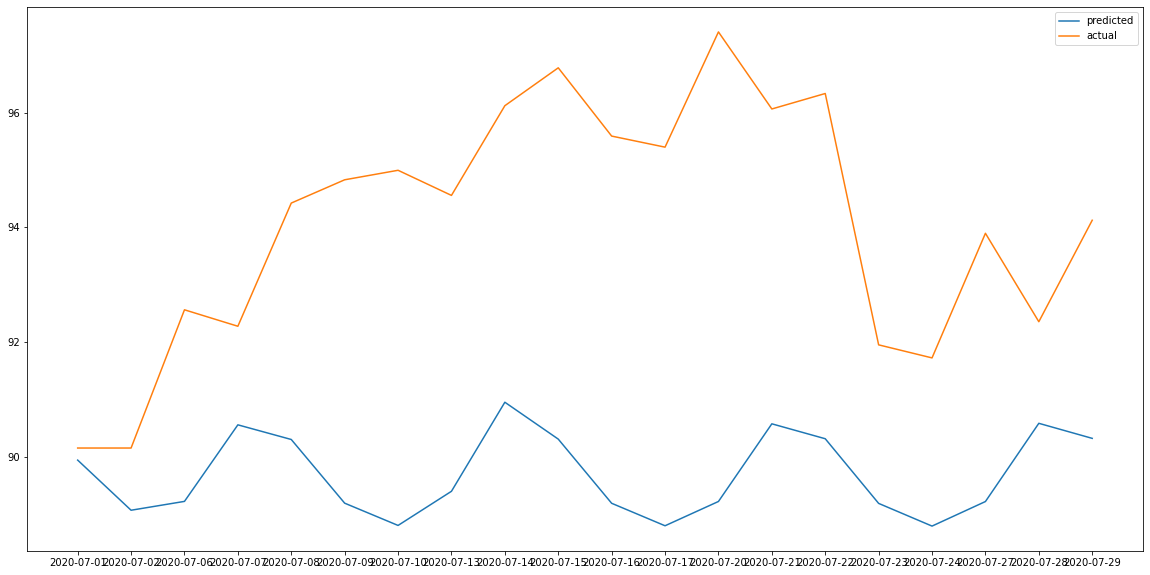

In [75]:
import matplotlib.pyplot as plt

play_df = pd.read_csv('test_range_2020-6-30.csv').set_index('Date')[:20]
plt.figure(figsize=(20,10))
plt.plot(play_df.index, play_df['forecast_value'], label='predicted')
plt.plot(play_df.index, play_df['Adj_Close'], label='actual')
plt.legend()
plt.show()

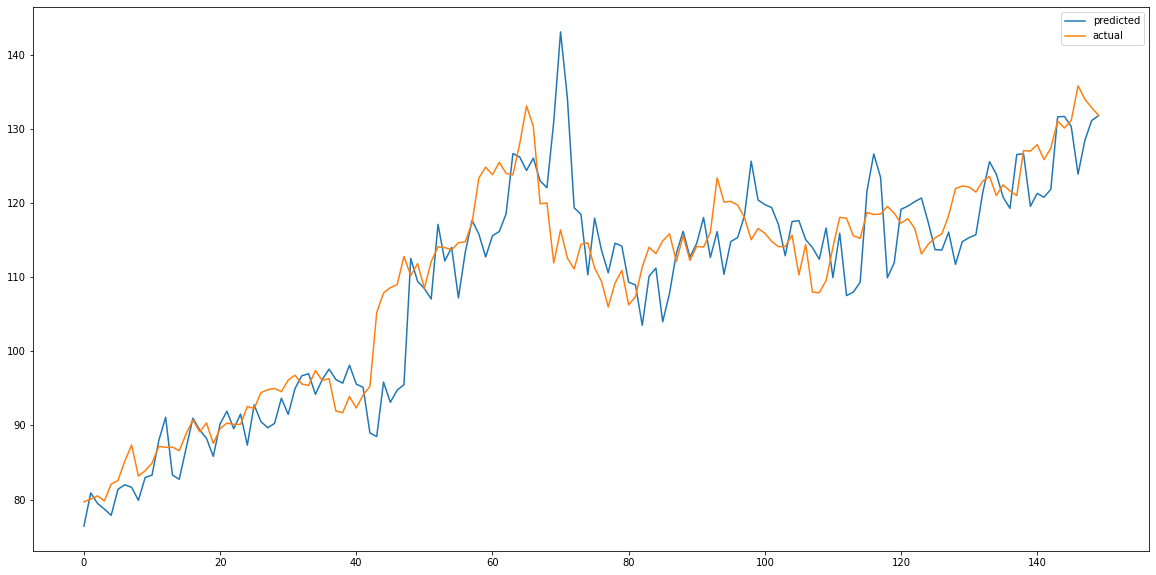

In [74]:
play_df = pd.read_csv('aapl_arima_val.csv')[:200]
plt.figure(figsize=(20,10))
plt.plot(play_df.index, play_df['arima_predicted'], label='predicted')
plt.plot(play_df.index, play_df['y_actual'], label='actual')
plt.legend()
plt.show()

In [43]:
query7 = f"DROP MODEL IF EXISTS `{project_id}.main.{model_name}`"
client.query(query7)

query8 = f"""
                CREATE MODEL IF NOT EXISTS `{project_id}.main.{model_name}`
                    OPTIONS(MODEL_TYPE='ARIMA_PLUS',
                             time_series_timestamp_col='Date',
                             time_series_data_col='Adj_Close',
                             DATA_FREQUENCY = 'DAILY',
                             HOLIDAY_REGION = 'GLOBAL',
                             CLEAN_SPIKES_AND_DIPS = FALSE,
                             AUTO_ARIMA = FALSE,
                             NON_SEASONAL_ORDER = {NON_SEASONAL_ORDER},
                             INCLUDE_DRIFT = {INCLUDE_DRIFT},
                             HORIZON=1500) AS
                    SELECT Date, Adj_Close
                    FROM `{project_id}.main.{db_name}`
                    WHERE Date Between '{start_date}' AND '{end_date}'
                    ORDER BY Date ASC
            """
client.query(query8)

query9 = f"""SELECT * FROM ML.FORECAST(MODEL `{project_id}.main.{model_name}`,
                                            STRUCT(1500 AS horizon)
            )"""

while True:
    try:
        test_df = client.query(query9).to_dataframe()
            
        break
    except:
        sleep(1)
            
    
test_df['Date'] = test_df['forecast_timestamp'].apply(lambda x: x.date())
test_df = test_df[['Date', 'forecast_value']].set_index('Date')
comp_df = test_df.join(df[['Adj_Close']], how='inner')
comp_df['AE'] = abs(comp_df['Adj_Close']-comp_df['forecast_value'])
comp_df['SE'] = (comp_df['Adj_Close']-comp_df['forecast_value'])**2
#     comp_df = comp_df.reset_index() # make index a running number
    
    for error in ['AE', 'SE']:
        comp_df[f'M{error}'] = comp_df[error].cumsum()/(df.index+1)
    
#     comp_df.set_index('Date')
#     comp_df.to_csv(f'test_range_{end_date}.csv')

In [48]:
play_df = comp_df.reset_index()
play_df
# play_df['MAE'] = play_df['AE'].cumsum()/(df.index+1)
# play_df

,Date,forecast_value,Adj_Close,AE,SE
0,2018-07-02,44.640140,45.111362,0.471223,0.222051
1,2018-07-03,44.899344,44.325687,0.573657,0.329082
2,2018-07-05,44.840923,44.682377,0.158547,0.025137
3,2018-07-06,44.737609,45.301758,0.564148,0.318263
4,2018-07-09,44.710915,45.930775,1.219859,1.488057
...,...,...,...,...,...
878,2021-12-27,45.110661,180.330002,135.219340,18284.270044
879,2021-12-28,45.401141,179.289993,133.888853,17926.224874
880,2021-12-29,45.292017,179.380005,134.087988,17979.588515
881,2021-12-30,45.343324,178.199997,132.856673,17650.895676


In [41]:
play_df = pd.read_csv('test_range_2018-12-31.csv')
play_df['MAE']=play_df['AE'].cumsum()/(play_df.index+1)

play_df


,Date,forecast_value,Adj_Close,AE,SE,MAE
0,2019-01-02,37.771904,38.326294,0.554390,0.307349,0.554390
1,2019-01-03,37.953999,34.508713,3.445286,11.869998,1.999838
2,2019-01-04,37.255389,35.981861,1.273528,1.621874,1.757735
3,2019-01-07,37.711337,35.901779,1.809558,3.274500,1.770691
4,2019-01-08,37.869461,36.586174,1.283287,1.646826,1.673210
...,...,...,...,...,...,...
752,2021-12-27,37.905390,180.330002,142.424612,20284.769961,56.998461
753,2021-12-28,38.354969,179.289993,140.935024,19862.681073,57.109782
754,2021-12-29,39.502263,179.380005,139.877742,19565.782750,57.219409
755,2021-12-30,39.116992,178.199997,139.083005,19344.082314,57.327694


In [28]:
test_df = test_df.join(df[['Adj_Close']], how='inner')

In [29]:
test_df['AE'] = abs(test_df['forecast_value']-test_df['Adj_Close'])
test_df['AE'].mean()

5.892906193410747

## Get Error Score

In [9]:


val_split = train_val_split(df, end='2021-12-31')
val_map = val_split.get_val_map(end='2021-12-31')
val_map

{'2020-05-22': '2020-06-01',
 '2020-05-26': '2020-06-02',
 '2020-05-27': '2020-06-03',
 '2020-05-28': '2020-06-04',
 '2020-05-29': '2020-06-05',
 '2020-06-01': '2020-06-08',
 '2020-06-02': '2020-06-09',
 '2020-06-03': '2020-06-10',
 '2020-06-04': '2020-06-11',
 '2020-06-05': '2020-06-12',
 '2020-06-08': '2020-06-15',
 '2020-06-09': '2020-06-16',
 '2020-06-10': '2020-06-17',
 '2020-06-11': '2020-06-18',
 '2020-06-12': '2020-06-19',
 '2020-06-15': '2020-06-22',
 '2020-06-16': '2020-06-23',
 '2020-06-17': '2020-06-24',
 '2020-06-18': '2020-06-25',
 '2020-06-19': '2020-06-26',
 '2020-06-22': '2020-06-29',
 '2020-06-23': '2020-06-30',
 '2020-06-24': '2020-07-01',
 '2020-06-25': '2020-07-02',
 '2020-06-26': '2020-07-06',
 '2020-06-29': '2020-07-07',
 '2020-06-30': '2020-07-08',
 '2020-07-01': '2020-07-09',
 '2020-07-02': '2020-07-10',
 '2020-07-06': '2020-07-13',
 '2020-07-07': '2020-07-14',
 '2020-07-08': '2020-07-15',
 '2020-07-09': '2020-07-16',
 '2020-07-10': '2020-07-17',
 '2020-07-13':

In [10]:
df['y_actual'] = df['Adj_Close'].shift(-5)
df.tail(10)

,Open,High,Low,Close,Adj_Close,Volume,y_actual
Date,,,,,,,
2021-12-27,177.089996,180.419998,177.070007,180.330002,180.330002,74919600,182.009995
2021-12-28,180.160004,181.330002,178.529999,179.289993,179.289993,79144300,179.699997
2021-12-29,179.330002,180.630005,178.139999,179.380005,179.380005,62348900,174.919998
2021-12-30,179.470001,180.570007,178.089996,178.199997,178.199997,59773000,172.000000
2021-12-31,178.089996,179.229996,177.259995,177.570007,177.570007,64025500,172.169998
2022-01-03,177.830002,182.880005,177.710007,182.009995,182.009995,104487900,NaN
2022-01-04,182.630005,182.940002,179.119995,179.699997,179.699997,99310400,NaN
2022-01-05,179.610001,180.169998,174.639999,174.919998,174.919998,94537600,NaN
2022-01-06,172.699997,175.300003,171.639999,172.000000,172.000000,96904000,NaN


In [11]:
def get_prediction_dict(df, dic, end_date, tgt_date):
    df['tgt_date'] = df['forecast_timestamp'].apply(lambda x: dt.strftime(x, '%Y-%m-%d'))
    dic[end_date] = df.set_index('tgt_date').loc[tgt_date, 'forecast_value']
    

In [ ]:
from tqdm import tqdm
from time import sleep

start_date = '2018-01-01'
model_name = 'arima_model'
pred_dict = {}

for k, v in tqdm(val_map.items()):
    
    query4 = f"DROP MODEL IF EXISTS `{project_id}.main.{model_name}`"
    client.query(query4)

    query5 = f"""
            CREATE MODEL IF NOT EXISTS `{project_id}.main.{model_name}`
                OPTIONS(MODEL_TYPE='ARIMA_PLUS',
                         time_series_timestamp_col='Date',
                         time_series_data_col='Adj_Close',
                         DATA_FREQUENCY = 'DAILY',
                         HOLIDAY_REGION = 'GLOBAL',
                         CLEAN_SPIKES_AND_DIPS = FALSE,
                         AUTO_ARIMA = FALSE,
                         NON_SEASONAL_ORDER = {NON_SEASONAL_ORDER},
                         INCLUDE_DRIFT = {INCLUDE_DRIFT}) AS
                SELECT Date, Adj_Close
                FROM `{project_id}.main.{db_name}`
                WHERE Date Between '{start_date}' AND '{k}'
                ORDER BY Date ASC
        """

    client.query(query5).to_dataframe()

    query6 = f"""SELECT * FROM ML.FORECAST(MODEL `{project_id}.main.{model_name}`,
                                        STRUCT(20 AS horizon)
                )"""

    while True:
        try:
            forecast_df = client.query(query6).to_dataframe()
            break
        except:
            sleep(1)
            
    get_prediction_dict(forecast_df, pred_dict, k, v)

  0%|▏                                                                                | 1/402 [00:15<1:43:58, 15.56s/it]

In [ ]:
pred_df = pd.DataFrame(pred_dict,index=['arima_predicted']).T
pred_df.index = pd.to_datetime(pred_df.index)
len(pred_df)

In [ ]:
pred_df = pred_df.join(df[['y_actual']], how='inner')
pred_df

In [106]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

map1 = val_split.get_val_map()
comp_df = pred_df[(pred_df.index >= min(map1)) & (pred_df.index <= max(map1))]
# print(comp_df)

for error in ['mean_absolute_error', 'mean_squared_error']:
    print(error)
    print(eval(f"{error}(comp_df['y_actual'], comp_df['arima_predicted'])"))
    print()

mean_absolute_error
4.5926510975119665

mean_squared_error
39.80454612009772



In [107]:
map2 = val_split.get_val_map(start="2021-01-01", end="2021-12-31")
comp_df = pred_df[(pred_df.index >= min(map2)) & (pred_df.index <= max(map2))]
print(comp_df)

for error in ['mean_absolute_error', 'mean_squared_error']:
    print(error)
    print(eval(f"{error}(comp_df['y_actual'], comp_df['arima_predicted'])"))
    print()

            arima_predicted    y_actual
2020-12-24       131.526587  128.617111
2020-12-28       139.727464  130.207291
2020-12-29       131.877740  125.824318
2020-12-30       131.590721  130.117859
2020-12-31       129.311885  131.240906
...                     ...         ...
2021-12-17       164.961542  180.330002
2021-12-20       164.208711  179.289993
2021-12-21       168.186904  179.380005
2021-12-22       167.876654  178.199997
2021-12-23       168.054580  177.570007

[252 rows x 2 columns]
mean_absolute_error
4.660548678297973

mean_squared_error
38.96172179468353



## Pickle pred_df

In [1]:
import pandas as pd

pred_df = pd.read_csv("aapl_arima_pred.csv")
pred_df

FileNotFoundError: [Errno 2] No such file or directory: 'aapl_arima_pred.csv'